In [1]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
import tkinter as tk
from tkinter import ttk, messagebox
import webbrowser

In [2]:
API_KEY = '24ecd5b5e52b45fd80da83e6c2db71b6'  # Replace with your NewsAPI.org key
BASE_URL = 'https://newsapi.org/v2/top-headlines'
CACHE_FILE = 'news_cache.json'

In [3]:
# Supported Categories
CATEGORIES = [
    'business', 'entertainment', 'general', 'health', 'science', 'sports', 'technology'
]


In [4]:
# Cell 2: Define Article Class
class Article:
    def __init__(self, title, source, url, content=None, author=None, published_at=None):
        self.title = title
        self.source = source
        self.url = url
        self.content = content
        self.author = author
        self.published_at = published_at

    def to_dict(self):
        return self.__dict__


In [5]:
class WebScraper:
    def scrape(self, article):
        try:
            response = requests.get(article.url, timeout=5)
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')
            text = ' '.join(p.get_text() for p in paragraphs[:5])
            article.content = text

            if not article.author:
                author_tag = soup.find('meta', {'name': 'author'})
                if author_tag:
                    article.author = author_tag.get('content', 'Unknown')

            if not article.published_at:
                date_tag = soup.find('meta', {'property': 'article:published_time'})
                if date_tag:
                    article.published_at = date_tag.get('content')

        except Exception:
            article.content = 'Content unavailable.'
        return article

In [6]:
class NewsFetcher:
    def __init__(self, api_key):
        self.api_key = api_key

    def fetch(self, category='general', limit=5):
        params = {
            'apiKey': self.api_key,
            'category': category,
            'country': 'us',
            'pageSize': limit
        }
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        articles = []
        for a in data.get('articles', []):
            articles.append(Article(
                title=a['title'],
                source=a['source']['name'],
                url=a['url'],
                author=a.get('author'),
                published_at=a.get('publishedAt')
            ))
        return articles

In [7]:
class NewsAggregator:
    def __init__(self):
        self.fetcher = NewsFetcher(API_KEY)
        self.scraper = WebScraper()
        self.cache = self.load_cache()

    def load_cache(self):
        if os.path.exists(CACHE_FILE):
            with open(CACHE_FILE, 'r') as f:
                return json.load(f)
        return {}

    def save_cache(self):
        with open(CACHE_FILE, 'w') as f:
            json.dump(self.cache, f)

    def get_articles(self, category='general', limit=5):
        key = f'{category}:{limit}'
        if key in self.cache:
            return [Article(**a) for a in self.cache[key]]

        articles = self.fetcher.fetch(category, limit)
        for a in articles:
            self.scraper.scrape(a)

        self.cache[key] = [a.to_dict() for a in articles]
        self.save_cache()
        return articles

    def to_dataframe(self, articles):
        df = pd.DataFrame([a.to_dict() for a in articles])
        df.drop_duplicates(subset=['url'], inplace=True)
        df.fillna('N/A', inplace=True)
        return df

    def visualize(self, articles):
        df = self.to_dataframe(articles)
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot 1: Article count by source
        df['source'].value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title("Articles per Source")
        axs[0].set_ylabel("Count")
        axs[0].tick_params(axis='x', rotation=45)

        # Plot 2: Articles over time
        df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
        df = df.dropna(subset=['published_at'])

        if not df.empty:
            df['published_date'] = df['published_at'].dt.date
            date_counts = df.groupby('published_date').size()
            axs[1].plot(date_counts.index, date_counts.values, marker='o')
            axs[1].set_title("Articles Over Time")
            axs[1].set_ylabel("Count")
            axs[1].set_xlabel("Date")
            axs[1].tick_params(axis='x', rotation=45)
        else:
            axs[1].set_title("Articles Over Time")
            axs[1].text(0.5, 0.5, 'No valid dates available', ha='center', va='center')

        plt.tight_layout()
        plt.show()

In [8]:
class NewsAppGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("News Aggregator")
        self.aggregator = NewsAggregator()

        tk.Label(root, text="Category:").grid(row=0, column=0, padx=10, pady=10, sticky='e')
        self.category_var = tk.StringVar(value='general')
        self.category_menu = ttk.Combobox(root, textvariable=self.category_var, values=CATEGORIES)
        self.category_menu.grid(row=0, column=1, padx=10, pady=10)

        tk.Label(root, text="Articles:").grid(row=1, column=0, padx=10, pady=10, sticky='e')
        self.article_slider = tk.Scale(root, from_=1, to=20, orient='horizontal')
        self.article_slider.set(5)
        self.article_slider.grid(row=1, column=1, padx=10, pady=10)

        self.fetch_btn = tk.Button(root, text="Fetch News", command=self.fetch_news)
        self.fetch_btn.grid(row=2, column=0, padx=10, pady=10)

        self.visual_btn = tk.Button(root, text="Visualize", command=self.visualize)
        self.visual_btn.grid(row=2, column=1, padx=10, pady=10)

    def fetch_news(self):
        try:
            category = self.category_var.get()
            limit = self.article_slider.get()
            articles = self.aggregator.get_articles(category, limit)
            df = self.aggregator.to_dataframe(articles)
            df_view = df[['title', 'author', 'source', 'published_at', 'url']]

            table_window = tk.Toplevel(self.root)
            table_window.title("News Articles")

            columns = ('Title', 'Author', 'Source', 'Published At', 'URL')
            tree = ttk.Treeview(table_window, columns=columns, show='headings')

            for col in columns:
                tree.heading(col, text=col)
                tree.column(col, anchor='w', width=200)

            for _, row in df_view.iterrows():
                tree.insert('', 'end', values=(
                    row['title'], row['author'], row['source'], row['published_at'], row['url']
                ))

            tree.pack(fill='both', expand=True)

            scrollbar = ttk.Scrollbar(table_window, orient='vertical', command=tree.yview)
            tree.configure(yscroll=scrollbar.set)
            scrollbar.pack(side='right', fill='y')

            # Make URL clickable on double-click
            def open_link(event):
                selected = tree.focus()
                if selected:
                    values = tree.item(selected, 'values')
                    url = values[4]
                    if url.startswith('http'):
                        webbrowser.open_new_tab(url)

            tree.bind('<Double-1>', open_link)

        except Exception as e:
            messagebox.showerror("Error", str(e))

    def visualize(self):
        try:
            category = self.category_var.get()
            limit = self.article_slider.get()
            articles = self.aggregator.get_articles(category, limit)
            self.aggregator.visualize(articles)
        except Exception as e:
            messagebox.showerror("Error", str(e))

In [9]:
import unittest
class TestAggregator(unittest.TestCase):
    def setUp(self):
        self.a1 = Article("Title1", "CNN", "http://x.com/1")
        self.a2 = Article("Title2", "BBC", "http://x.com/2")
        self.a3 = Article("Title1", "CNN", "http://x.com/1")

    def test_creation(self):
        self.assertEqual(self.a1.title, "Title1")

    def test_dedup(self):
        agg = NewsAggregator()
        df = agg.to_dataframe([self.a1, self.a3])
        self.assertEqual(len(df), 1)

    def test_api_fetch(self):
        fetcher = NewsFetcher(API_KEY)
        result = fetcher.fetch('technology', 3)
        self.assertTrue(len(result) <= 3)

    def test_scrape(self):
        scraper = WebScraper()
        result = scraper.scrape(self.a1)
        self.assertIsNotNone(result.content)


In [10]:
    # Run the tests
    suite = unittest.TestLoader().loadTestsFromTestCase(TestAggregator)
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)


test_api_fetch (__main__.TestAggregator.test_api_fetch) ... ok
test_creation (__main__.TestAggregator.test_creation) ... ok
test_dedup (__main__.TestAggregator.test_dedup) ... ok
test_scrape (__main__.TestAggregator.test_scrape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 14.811s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

C:\Users\Shadbin Eshad\AppData\Local\Temp\ipykernel_5936\2831712213.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')


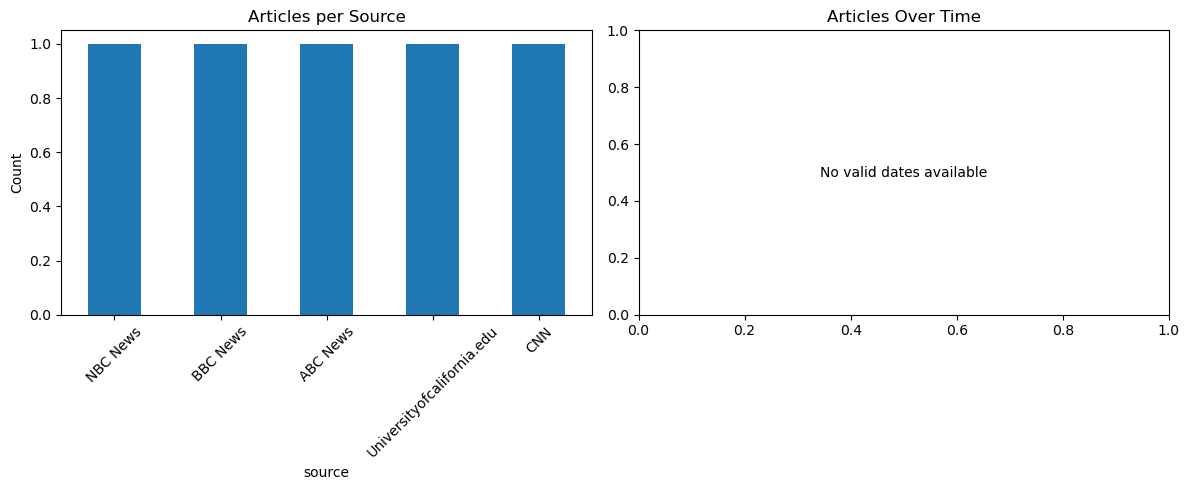

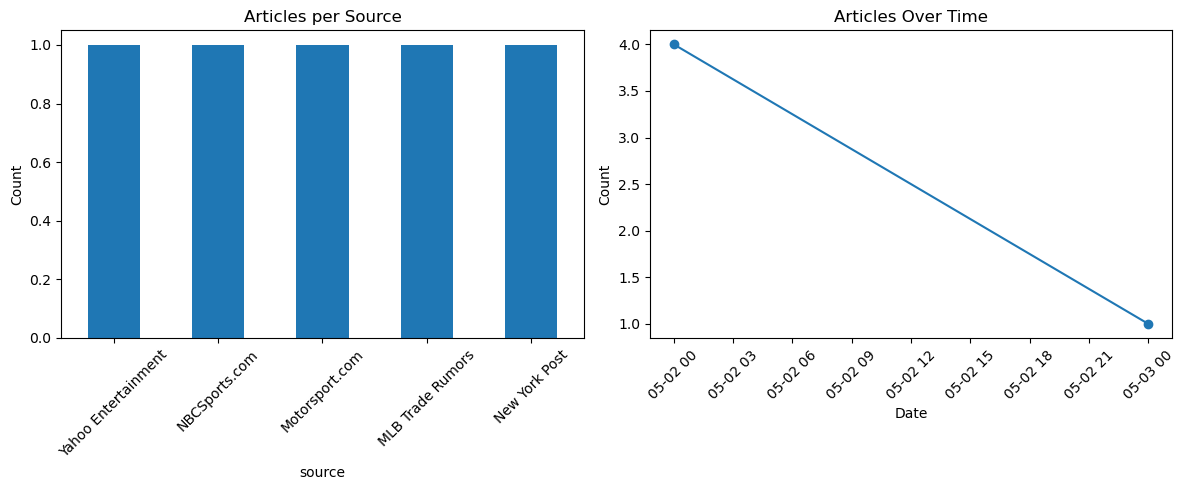

In [ ]:
if __name__ == "__main__":
    root = tk.Tk()
    app = NewsAppGUI(root)
    root.mainloop()